In [1]:
from pyscf import gto, scf, fci, mcscf
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
import os
from qiskit import transpile
from qiskit_aer import AerSimulator, AerProvider
from math import comb
import time

from scipy.sparse.linalg import eigsh
from qiskit_ibm_runtime import QiskitRuntimeService


## 함수

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
    token='Wx06bez50boLXEdw3IbqpoDa8gwHcURc9lQT0D_SRxJP', # Your token is confidential.
    # Do not share your key in public code.
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/624a449c58db4cebbbcd6d44cd96889e:354c61a9-e812-433b-a108-1e267e668f64::",
    name=".", # Optionally name this set of account credentials.
    set_as_default=True, # Optionally set these as your default credentials.
    overwrite=True
  )

In [3]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_fez")
backend = AerSimulator(method = "statevector",noise_model=None)

In [4]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper
    # 고전값 비교용 FCI 
    # H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
    
def hamming_distance(state1, state2):
    """Number of differing bits"""
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def str_to_bitstate(state_str):
    """
    문자열 ket 상태 "0101..." → int로 변환.
    문자열 왼쪽이 큐빗 N-1, 오른쪽이 큐빗0이라고 가정.
    """
    return int(state_str, 2)

def bitstate_to_str(state_int, n_qubits):
    """
    int ket 상태 → n_qubits 길이의 이진 문자열로 변환.
    """
    return format(state_int, f'0{n_qubits}b')

def apply_pauli_string_bits(state, pauli_string, n_qubits):
    """
    state: int로 표현된 ket. ex) 0b0101 → 5
    pauli_string: 문자열. 예) "XIZY..."
    n_qubits: 큐빗 수
    
    Returns:
        (new_state: int, phase: complex)
    """
    phase = 1.0
    # 큐빗0을 오른쪽(Little Endian)으로 가정하므로, pauli_string은 오른쪽부터 큐빗0 → 왼쪽 큐빗N-1
    for i, p in enumerate(reversed(pauli_string)):  # LSB부터 순회
        bit = (state >> i) & 1
        if p == 'I':
            continue
        elif p == 'Z':
            if bit:
                phase *= -1
        elif p == 'X':
            state ^= (1 << i)  # i번째 비트 flip
        elif p == 'Y':
            if bit:
                phase *= -1j
            else:
                phase *= 1j
            state ^= (1 << i)
    return state, phase

def apply_pauli_string(state_str, pauli_string):
    """
    state_str: "0101..." 형태의 ket 문자열 (왼쪽이 큐빗 N-1, 오른쪽이 큐빗0)
    pauli_string: "XIZY..." 형태의 파울리 연산 문자열
    
    Returns:
        (new_state_str, phase)
    """
    n_qubits = len(pauli_string)
    state_int = str_to_bitstate(state_str)
    new_state_int, phase = apply_pauli_string_bits(state_int, pauli_string, n_qubits)
    new_state_str = bitstate_to_str(new_state_int, n_qubits)
    return new_state_str, phase

def inner_product_pauli_hamiltonian(pauli_op, basis_bra_str, basis_ket_str):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.
    pauli_op: Qiskit's PauliSumOp 또는 pauli_op.to_list()를 지원하는 형태
    basis_bra_str, basis_ket_str: "0101..." 형태의 ket 문자열
    
    Returns: float (real part of <bra|H|ket>)
    """
    n_qubits = len(basis_bra_str)
    basis_bra_int = str_to_bitstate(basis_bra_str)
    basis_ket_int = str_to_bitstate(basis_ket_str)
    
    total = 0.0
    for pauli_string, coeff in pauli_op.to_list():
        new_state_int, phase = apply_pauli_string_bits(basis_ket_int, pauli_string, n_qubits)
        if new_state_int == basis_bra_int:
            total += coeff * phase
            
    return total.real

def project_hamiltonian(basis,hamiltonian):
    n = len(basis)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = basis[i]
            basis_ket = basis[j]
            inner_product = inner_product_pauli_hamiltonian(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 

            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    return H 

def particle_count(s):
    n = len(s)
    half = n // 2
    left = s[:half].count('1')
    right = s[half:].count('1')
    return left, right

def flip_one_pair(s, zero_idx, one_idx):
    """
    문자열 s에서 zero_idx는 '0'이어야 하고 → '1'로 바꾸고,
    one_idx는 '1'이어야 하고 → '0'으로 바꿈
    """
    s = list(s)
    assert s[zero_idx] == '0', f"Index {zero_idx} is not 0"
    assert s[one_idx] == '1', f"Index {one_idx} is not 1"
    s[zero_idx] = '1'
    s[one_idx] = '0'
    return ''.join(s)

def one_step_states_constrained(s):
    """1번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    zeros = [i for i, c in enumerate(s) if c == '0']
    ones = [i for i, c in enumerate(s) if c == '1']
    target_left, target_right = particle_count(s)

    states = set()
    for zi in zeros:
        for oi in ones:
            if zi == oi:
                continue
            new_s = flip_one_pair(s, zi, oi)
            l, r = particle_count(new_s)
            if l == target_left and r == target_right:
                states.add(new_s)
    return states

def two_step_states_constrained(s):
    """2번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    step1 = one_step_states_constrained(s)
    states = set()
    for inter in step1:
        states.update(one_step_states_constrained(inter))
    states.discard(s)  # 자기 자신은 제외
    return states

def calc_total_space(n,k):
    alpha_spin_orbital =int(n/2)
    alpha_electron = int(k/2)
    dim = (comb(alpha_spin_orbital, alpha_electron))**2
    return dim
    

In [5]:
def Circuit_Preperation(hamiltonian, E_problem,mapper, which_ansatz):
    #헤밀토니안이랑 driver 주어지면, 회로 생성. 
    num_qubits = hamiltonian.num_qubits
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
    if which_ansatz == "uccsd":
        ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state,generalized=True)
    elif which_ansatz == "twolocal": 
        ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state)
    else : 
        print("ansatz 입력 틀림 uccsd or twolocal ")
    return ansatz

def sampling_Filtering(ansatz, parameter, backend, num_particles):
    # 측정해서 spin이랑 그런거 맞는거만 필터링
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    time2 = time.time()

    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()

    job = backend.run(transpile(qc, backend), shots=1000)
    result = job.result()

    # Counts 얻기
    counts = result.get_counts(qc)
    total_shots = sum(counts.values())
    probs = [(bitstring, count / total_shots) for bitstring, count in counts.items()]

    all_basis = []
    all_prob = []

    for bitstring, prob in probs:
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if left_ones==num_particles[1] and right_ones == num_particles[0]:
            all_basis.append(bitstring)
            all_prob.append(prob)
    all_basis = np.array(all_basis)
    #print(len(all_basis))
    all_prob = np.array(all_prob)
        # ... 코드 ...
    
    print("-----------------------")
    print(f"Sampling : {time.time() - time2:.6f}초")
    return all_basis

def construct_c_i(all_basis, C_i_1):
    c_i = all_basis | C_i_1
    return c_i    

def screening(all_basis,hamiltonian,k):
    time2 = time.time()
    screened_space = []
    H = project_hamiltonian(all_basis,hamiltonian)
    eigenvalue, eigenvector = eigsh(H, k=1, which='SA')  # SA: smallest algebraic
    
    v0 = eigenvector[:, 0]  # 가장 작은 고유값에 대응하는 고유벡터
    indices = np.argsort(np.abs(v0))[-k:]  # 절댓값 기준으로 큰 순서대로 k개
    important_states = indices[::-1]  # 큰 순서대로 정렬
    
    #print(important_states)
    for idx in important_states:
        screened_basis = all_basis[idx]
        screened_space.append(screened_basis)
        
    print(f"Screening : {time.time() - time2:.6f}초")
    
    
    return screened_space


def energy_calc(screened_space,hamiltonian):
    time2 = time.time()
    mat = project_hamiltonian(screened_space,hamiltonian)  
    eigvals, eigvecs = np.linalg.eigh(mat)
    # 가장 작은 고윳값
    smallest_eigenvalue = eigvals[0]
    smallest_eigvec = eigvecs[0]
    #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
    print(f"energy calc: {time.time() - time2:.6f}초")
    
    return smallest_eigenvalue, smallest_eigvec

def post_screening(smallest_eigvec, screened_space, eps):
    time2 = time.time()
    low_contrib_space = []
    low_contrib_indices = np.where(np.abs(smallest_eigvec) < eps)[0]
    for idx in low_contrib_indices:
        low_contrib_state = screened_space[idx]
        low_contrib_space.append(low_contrib_state)
    post_screened_space = list(set(screened_space) - set(low_contrib_space))
    print(f"post screening: {time.time() - time2:.6f}초")
    return post_screened_space 

def classical_expansion(smallest_eigvec,screened_space,post_screened_space):
    time2 = time.time()
    max_index = np.argmax(np.abs(smallest_eigvec))
    s = screened_space[max_index]
    s1_constrained = one_step_states_constrained(s)
    s2_constrained = two_step_states_constrained(s)
    #print(s1_constrained)
    #print(s2_constrained)
    excitation_expansion = s1_constrained.union(s2_constrained)
    total_expansion = excitation_expansion.union(post_screened_space)    
    print(f"calssical expansion: {time.time() - time2:.6f}초")
    return list(total_expansion), list(excitation_expansion)

In [6]:
class CostWithHistoryList:
    def __init__(self, hamiltonian, ansatz, backend, num_electrons, num_determinant, eps, num_particles,core,repulsion ,threshold=1e-4):

        self.prev_list = []
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.backend = backend
        self.num_electrons = num_electrons
        self.num_determinant = num_determinant
        self.eps = eps
        self.num_particles = num_particles
        self.core =core
        self.repulsion = repulsion
        # 저장소
        self.ith_space = None
        self.expanded_space = None
        self.energy_history = []
        self.iteration = 0
        self.threshold = threshold

        # 수렴 추적용
        self.prev_energies = []
        self.converged_count = 0

    def __call__(self, parameter):
        time2 = time.time()
        current_list = list(self.compute_current_list(parameter))
        self.prev_list = list(set(self.prev_list + current_list))

        # 에너지 계산
        screened_space = screening(self.prev_list, self.hamiltonian, self.num_determinant)
        Energy, ground_state = energy_calc(screened_space, self.hamiltonian)
        post_screened_space = post_screening(ground_state, screened_space, self.eps)
        

        # 저장
        self.ith_space, self.expanded_space = classical_expansion(ground_state,screened_space,post_screened_space)
        self.iteration += 1
        self.energy_history.append(Energy)

        # 에너지 변화량 추적
        if self.prev_energies:
            delta = abs(Energy - self.prev_energies[-1])
            if delta < self.threshold:
                self.converged_count += 1
            else:
                self.converged_count = 0

            if self.converged_count >= 3:
        
                print(f"🔚 조기 종료: ΔE < {self.threshold} 가 3회 연속 만족됨.")
                raise StopIteration

        self.prev_energies.append(Energy)

        print(f"each iteration: {time.time() - time2:.6f}초")
        print(f"Iter {self.iteration}: Energy = {Energy +self.repulsion + self.core:.6f}")
        print("-----------------------")
        
        return Energy

    def compute_current_list(self, parameter):
        return sampling_Filtering(self.ansatz, parameter, self.backend, self.num_particles)

In [7]:
def HIVQE(E_problem,k):
    num_spin_orbital = 2*E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    total_dim = calc_total_space(num_spin_orbital,num_electrons)
    # Transformer 적용
    #E_problem = active_transformer.transform(problem)
    # 여기는 이후, As_transformer 로 변경. 
    fermionic_hamiltonian = E_problem.hamiltonian
    repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
    core = fermionic_hamiltonian.constants['ActiveSpaceTransformer']
    second_q_op = fermionic_hamiltonian.second_q_op()
    hamiltonian,mapper = fermion_to_qubit(E_problem, second_q_op, "JW")

    time1 = time.time() #헤밀토니안 구성
    # ... 코드 ...
    eps = 10**(-5)
    Chem_accuracy = 0.0016
    ansatz = Circuit_Preperation(hamiltonian, E_problem,mapper, "twolocal")
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    cost_func = CostWithHistoryList(
        hamiltonian=hamiltonian,
        ansatz=ansatz,
        backend=backend,
        num_electrons=num_electrons,
        num_determinant=k,
        eps=eps,
        num_particles = num_particles,
        core = core,
        repulsion= repulsion
    )


    try:
        res = minimize(
            cost_func,
            x0,
            method="cobyla",
            options={"maxiter": 20, "disp": True}
        )
        
    except StopIteration:
        print("⚠️ Optimization stopped early due to convergence criteria.")

        
    plt.plot(cost_func.energy_history+core+repulsion, marker='x', linestyle='-' ,label = "HIVQE")
    #plt.axhline(E_HF, label = "HF")
    #plt.axhline(E_FCI, color ='r',ls= '--',label = "Numpy_minimum_eigensolver")
    plt.ticklabel_format(style='plain', axis='y')  # 과학적 표기 X
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # 일반 숫자 포맷
    plt.gca().ticklabel_format(useOffset=False, style='plain')  # 진짜 값으로
    plt.title("Energy")
    plt.xlabel("Iteration")
    plt.ylabel("Energy(hartree)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
    plt.grid()
    plt.show()
        
    energy = cost_func.energy_history[-1]
    return energy

## 구조

In [8]:
C = 1.9220
L = 2.0946
theta = np.deg2rad(94.24)

Co = (0,0,0)
O_1 = (C,0,0)
O_2 = (C*np.cos(theta),C*np.sin(theta),0)
Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)

basis = 'sto-3g'
O_Li_dimer_atoms = ["Co","O", "O", "Li"]
O_Li_dimer_coords = [Co,O_1,O_2, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 1

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,6), 12)
as_problem = as_transformer.transform(E_problem)
num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)



853776


-----------------------
Sampling : 11.241625초
Screening : 192.291382초
energy calc: 191.599538초
post screening: 0.000026초
calssical expansion: 0.006964초
each iteration: 395.139879초
Iter 1: Energy = -1520.237604
-----------------------
-----------------------
Sampling : 10.560178초
Screening : 794.190312초
energy calc: 793.245940초
post screening: 0.000096초
calssical expansion: 0.014778초
each iteration: 1598.015411초
Iter 2: Energy = -1520.237716
-----------------------
-----------------------
Sampling : 10.486336초
Screening : 14392.871632초
energy calc: 24785.813491초
post screening: 0.000107초
calssical expansion: 0.018996초
each iteration: 39189.191512초
Iter 3: Energy = -1520.237731
-----------------------
-----------------------
Sampling : 10.415196초
Screening : 34880.288075초
energy calc: 2766.277957초
post screening: 0.000140초
calssical expansion: 0.017937초
each iteration: 37657.000456초
Iter 4: Energy = -1520.255004
-----------------------
-----------------------
Sampling : 10.540705초
Screen

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


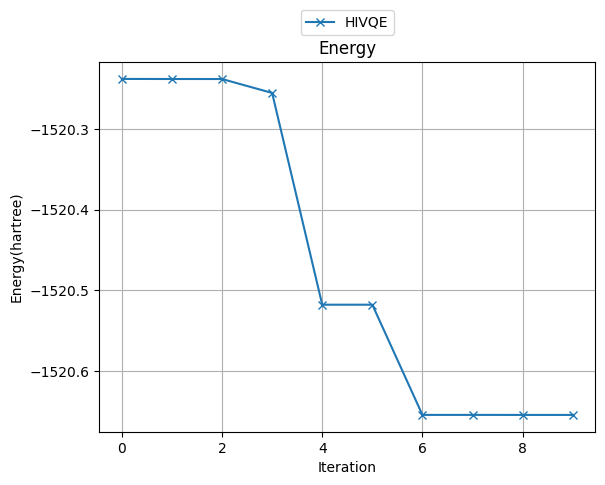

In [9]:
E = HIVQE(as_problem, 2000)